# CS202 Assignment 3

## Imports

In [2]:
import torch
import sacrebleu
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from radon.complexity import cc_visit
from radon.metrics import mi_visit
from radon.raw import analyze
from transformers import AutoTokenizer, AutoModel

## Basline Statistics

In [3]:
bugfix_files = pd.read_csv('bugfix_commit_files.csv', escapechar='\\')
bugfix_files.fillna('', inplace=True)

In [4]:
bugfix_files.head()

,Hash,Message,Filename,Source Code (Before),Source Code (current),Diff,LLM Inference,Rectified Message
0,014a277a97759bbc0e6ec8fba588bc6e6de65a86,A few fixes to initial point_thickness impleme...,constants.py,import os\nimport numpy as np\n\n\nGENERALLY_B...,import os\nimport numpy as np\n\nPRODUCTION_QU...,"@@ -1,9 +1,6 @@\n import os\n import numpy as ...",add more examples to the example,A few fixes to initial point_thickness impleme...
1,014a277a97759bbc0e6ec8fba588bc6e6de65a86,A few fixes to initial point_thickness impleme...,displayer.py,import numpy as np\nimport itertools as it\nim...,import numpy as np\nimport itertools as it\nim...,"@@ -55,7 +55,7 @@ def paint_mobjects(mobjects,...",add nudge to the thickness calculation,A few fixes to initial point_thickness impleme...
2,014a277a97759bbc0e6ec8fba588bc6e6de65a86,A few fixes to initial point_thickness impleme...,mobject.py,import numpy as np\nimport itertools as it\nim...,import numpy as np\nimport itertools as it\nim...,"@@ -21,7 +21,7 @@ class Mobject(object):\n ...",add missing docstring,Update configuration inheritance in Mobject cl...
3,ac930952f151acf284f6e01e98e8f7256f29f9f4,"Beginning transform KA article, many small fix...",animation.py,from PIL import Image\nfrom colour import Colo...,from PIL import Image\nfrom colour import Colo...,"@@ -4,7 +4,6 @@ import numpy as np\n import wa...",add missing code in animation,Update starting_mobject initialization in Anim...
4,ac930952f151acf284f6e01e98e8f7256f29f9f4,"Beginning transform KA article, many small fix...",meta_animations.py,import numpy as np\nimport itertools as it\nfr...,import numpy as np\nimport itertools as it\n\n...,"@@ -1,6 +1,5 @@\n import numpy as np\n import ...",add missing import,add missing import


In [5]:
info = pd.DataFrame({
	"Total Bugfix Commits": [int(bugfix_files['Hash'].nunique())],
	"Total Bugfix commit Modified files": [int(len(bugfix_files))],
	"Average number of files changed per commit": [float(bugfix_files.groupby('Hash').size().mean())]
}).T

info.columns = ['Value']
info

,Value
Total Bugfix Commits,838.000000
Total Bugfix commit Modified files,1432.000000
Average number of files changed per commit,1.708831


### Most frequent commit types

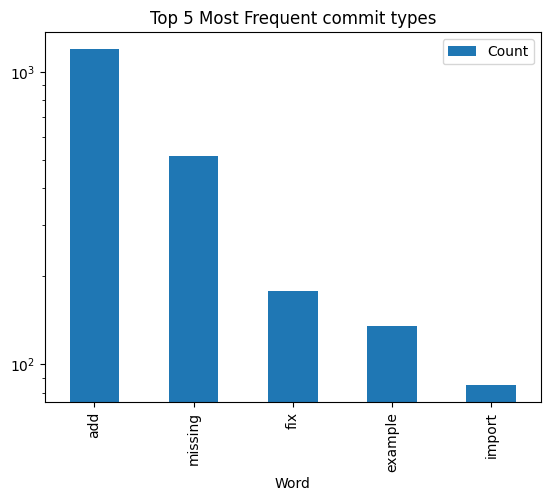

In [6]:
word_count = {}

for index, row in bugfix_files.iterrows():
    for word in row['LLM Inference'].split():
        word = word.lower()
        word_count[word] = word_count.get(word, 0) + 1

# Sort the word count dictionary by values in descending order and get top 5
# Filter out 'to' and 'the' from word_count before sorting
filtered_word_count = {word: count for word, count in word_count.items() if word not in ['to', 'the', 'more', 'for', 'in', 'scene']}
top_5_words = sorted(filtered_word_count.items(), key=lambda x: x[1], reverse=True)[:5]

# Create a DataFrame for plotting
top_5_df = pd.DataFrame(top_5_words, columns=['Word', 'Count'])

# Plot the top 5 words
top_5_df.plot(x='Word', y='Count', kind='bar', title='Top 5 Most Frequent commit types')
plt.yscale('log')

In [7]:
top_5_df

,Word,Count
0,add,1196
1,missing,514
2,fix,178
3,example,135
4,import,85


### Most frequent modified file types (by extension)

Text(0, 0.5, 'Count (log scale)')

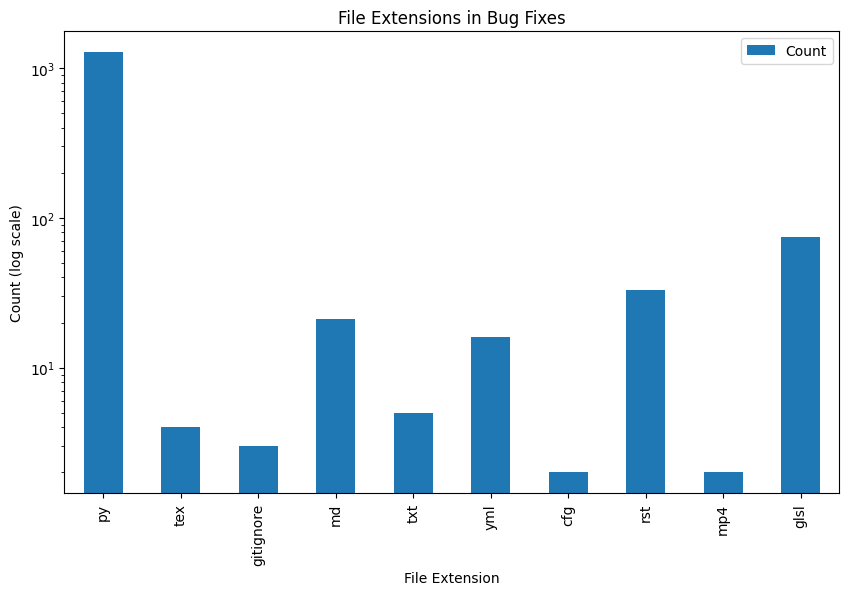

In [8]:
file_extension_counts = {}

for index, row in bugfix_files.iterrows():
    if '.' not in row['Filename']:
        continue
    file_extension = row['Filename'].split('.')[-1]
    file_extension_counts[file_extension] = file_extension_counts.get(file_extension, 0) + 1

# Create a DataFrame for plotting
file_extension_df = pd.DataFrame(file_extension_counts.items(), columns=['File Extension', 'Count'])

# Plot the file extensions
file_extension_df.plot(x='File Extension', y='Count', kind='bar', title='File Extensions in Bug Fixes', figsize=(10, 6))
plt.yscale('log')
plt.ylabel('Count (log scale)')

## Computing structural metrics

In [9]:
def compute_metrics(code):
	try:
		cc = sum(block.complexity for block in cc_visit(code))
		mi = mi_visit(code, True)
		loc = analyze(code).loc
		return cc, mi, loc
	except Exception as e:
		# print(e)
		return 0, 0, 0

for index, row in tqdm(bugfix_files.iterrows(), total=len(bugfix_files)):
	cc_before, mi_before, loc_before = compute_metrics(bugfix_files.at[index, 'Source Code (Before)'])
	cc_after, mi_after, loc_after = compute_metrics(bugfix_files.at[index, 'Source Code (current)'])
	bugfix_files.at[index, 'MI_Change'] = mi_after - mi_before
	bugfix_files.at[index, 'CC_Change'] = cc_after - cc_before
	bugfix_files.at[index, 'LOC_Change'] = loc_after - loc_before

100%|██████████| 1432/1432 [03:23<00:00,  7.05it/s]


In [10]:
bugfix_files.head()

,Hash,Message,Filename,Source Code (Before),Source Code (current),Diff,LLM Inference,Rectified Message,MI_Change,CC_Change,LOC_Change
0,014a277a97759bbc0e6ec8fba588bc6e6de65a86,A few fixes to initial point_thickness impleme...,constants.py,import os\nimport numpy as np\n\n\nGENERALLY_B...,import os\nimport numpy as np\n\nPRODUCTION_QU...,"@@ -1,9 +1,6 @@\n import os\n import numpy as ...",add more examples to the example,A few fixes to initial point_thickness impleme...,0.000000,0.0,-1.0
1,014a277a97759bbc0e6ec8fba588bc6e6de65a86,A few fixes to initial point_thickness impleme...,displayer.py,import numpy as np\nimport itertools as it\nim...,import numpy as np\nimport itertools as it\nim...,"@@ -55,7 +55,7 @@ def paint_mobjects(mobjects,...",add nudge to the thickness calculation,A few fixes to initial point_thickness impleme...,0.000000,0.0,0.0
2,014a277a97759bbc0e6ec8fba588bc6e6de65a86,A few fixes to initial point_thickness impleme...,mobject.py,import numpy as np\nimport itertools as it\nim...,import numpy as np\nimport itertools as it\nim...,"@@ -21,7 +21,7 @@ class Mobject(object):\n ...",add missing docstring,Update configuration inheritance in Mobject cl...,0.000000,0.0,0.0
3,ac930952f151acf284f6e01e98e8f7256f29f9f4,"Beginning transform KA article, many small fix...",animation.py,from PIL import Image\nfrom colour import Colo...,from PIL import Image\nfrom colour import Colo...,"@@ -4,7 +4,6 @@ import numpy as np\n import wa...",add missing code in animation,Update starting_mobject initialization in Anim...,0.225313,0.0,-1.0
4,ac930952f151acf284f6e01e98e8f7256f29f9f4,"Beginning transform KA article, many small fix...",meta_animations.py,import numpy as np\nimport itertools as it\nfr...,import numpy as np\nimport itertools as it\n\n...,"@@ -1,6 +1,5 @@\n import numpy as np\n import ...",add missing import,add missing import,0.268985,0.0,-1.0


In [11]:
bugfix_files.to_csv("bugfix_commit_files_MI_CC_LOC_Added.csv")

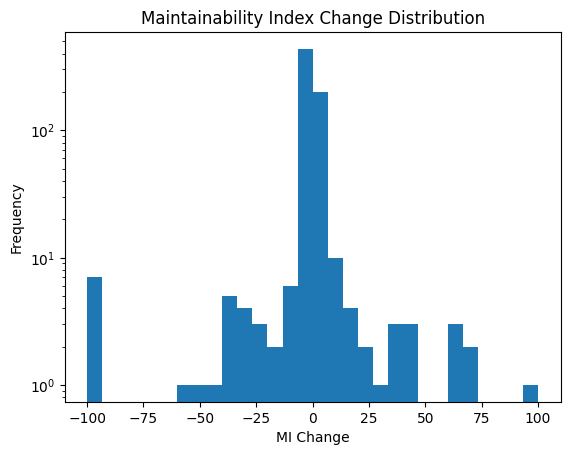

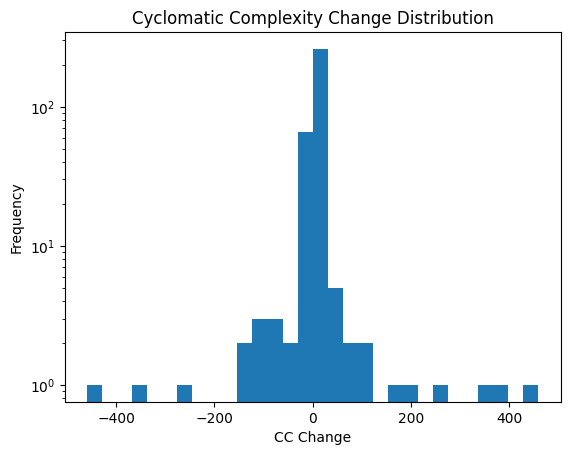

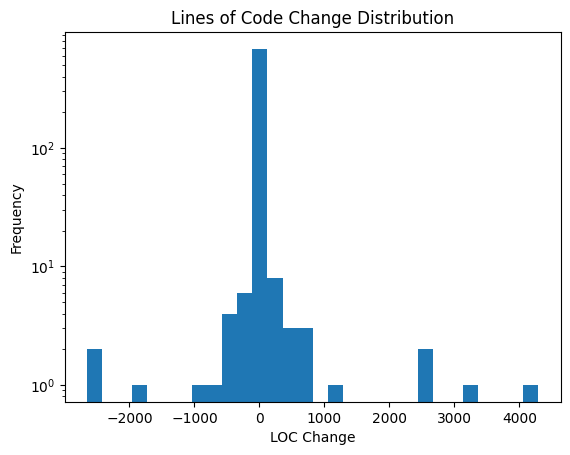

In [12]:
non_zero_mi = bugfix_files[bugfix_files['MI_Change'] != 0]['MI_Change']
non_zero_cc = bugfix_files[bugfix_files['CC_Change'] != 0]['CC_Change']
non_zero_loc = bugfix_files[bugfix_files['LOC_Change'] != 0]['LOC_Change']

plt.hist(non_zero_mi, bins=30)
plt.title('Maintainability Index Change Distribution')
plt.xlabel('MI Change')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

plt.hist(non_zero_cc, bins=30)
plt.title('Cyclomatic Complexity Change Distribution')
plt.xlabel('CC Change')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

plt.hist(non_zero_loc, bins=30)
plt.title('Lines of Code Change Distribution')
plt.xlabel('LOC Change')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

## Similarity Measures

In [13]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model = AutoModel.from_pretrained("microsoft/codebert-base").cuda()

def cosine_similarity(a, b):
    return (a * b).sum() / (np.linalg.norm(a) * np.linalg.norm(b))

for index, row in tqdm(bugfix_files.iterrows(), total=len(bugfix_files)):
    before = tokenizer("<s>" + row['Source Code (Before)'] + "</s>", return_tensors="pt", padding=True, truncation=True).to(model.device)
    after = tokenizer("<s>" + row['Source Code (current)'] + "</s>", return_tensors="pt", padding=True, truncation=True).to(model.device)

    with torch.no_grad():
        before_emb = model(**before).last_hidden_state[:, 0, :].cpu().numpy()
        after_emb = model(**after).last_hidden_state[:, 0, :].cpu().numpy()
    bugfix_files.at[index, 'Semantic_Similarity'] = cosine_similarity(before_emb, after_emb)
    bugfix_files.at[index, 'Token_Similarity'] = sacrebleu.corpus_bleu([row['Source Code (current)']], [[row['Source Code (Before)']]]).score / 100.0

100%|██████████| 1432/1432 [03:22<00:00,  7.07it/s]


In [11]:
bugfix_files.head()

,Hash,Message,Filename,Source Code (Before),Source Code (current),Diff,LLM Inference,Rectified Message,MI_Change,CC_Change,LOC_Change,Semantic_Similarity,Token_Similarity
0,014a277a97759bbc0e6ec8fba588bc6e6de65a86,A few fixes to initial point_thickness impleme...,constants.py,import os\nimport numpy as np\n\n\nGENERALLY_B...,import os\nimport numpy as np\n\nPRODUCTION_QU...,"@@ -1,9 +1,6 @@\n import os\n import numpy as ...",add more examples to the example,A few fixes to initial point_thickness impleme...,0.000000,0.0,-1.0,0.999902,0.988357
1,014a277a97759bbc0e6ec8fba588bc6e6de65a86,A few fixes to initial point_thickness impleme...,displayer.py,import numpy as np\nimport itertools as it\nim...,import numpy as np\nimport itertools as it\nim...,"@@ -55,7 +55,7 @@ def paint_mobjects(mobjects,...",add nudge to the thickness calculation,A few fixes to initial point_thickness impleme...,0.000000,0.0,0.0,1.000000,0.951255
2,014a277a97759bbc0e6ec8fba588bc6e6de65a86,A few fixes to initial point_thickness impleme...,mobject.py,import numpy as np\nimport itertools as it\nim...,import numpy as np\nimport itertools as it\nim...,"@@ -21,7 +21,7 @@ class Mobject(object):\n ...",add missing docstring,Update configuration inheritance in Mobject cl...,0.000000,0.0,0.0,0.999808,0.997525
3,ac930952f151acf284f6e01e98e8f7256f29f9f4,"Beginning transform KA article, many small fix...",animation.py,from PIL import Image\nfrom colour import Colo...,from PIL import Image\nfrom colour import Colo...,"@@ -4,7 +4,6 @@ import numpy as np\n import wa...",add missing code in animation,Update starting_mobject initialization in Anim...,0.225313,0.0,-1.0,0.999607,0.987431
4,ac930952f151acf284f6e01e98e8f7256f29f9f4,"Beginning transform KA article, many small fix...",meta_animations.py,import numpy as np\nimport itertools as it\nfr...,import numpy as np\nimport itertools as it\n\n...,"@@ -1,6 +1,5 @@\n import numpy as np\n import ...",add missing import,add missing import,0.268985,0.0,-1.0,0.999841,0.994031


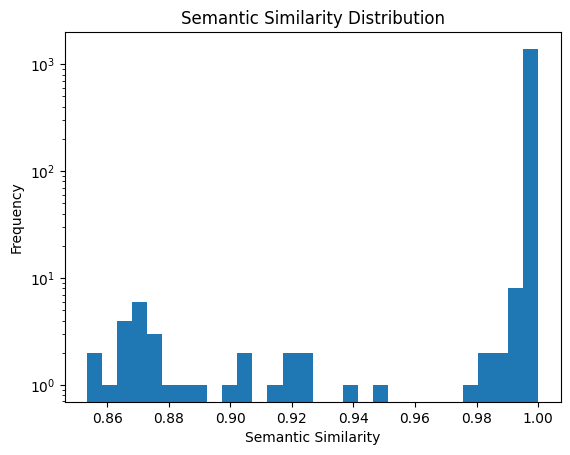

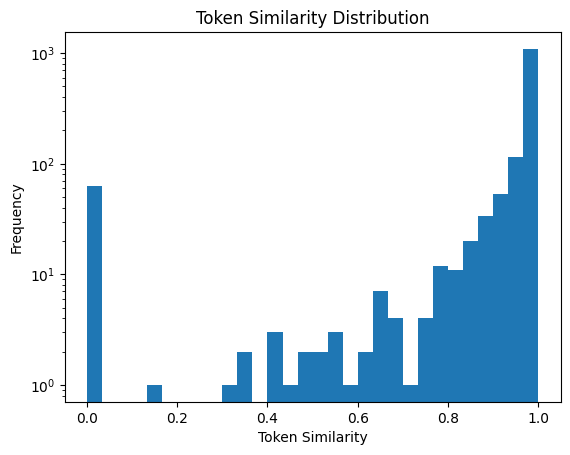

In [14]:
plt.hist(bugfix_files['Semantic_Similarity'], bins=30)
plt.title('Semantic Similarity Distribution')
plt.xlabel('Semantic Similarity')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()
plt.hist(bugfix_files['Token_Similarity'], bins=30)
plt.title('Token Similarity Distribution')
plt.xlabel('Token Similarity')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

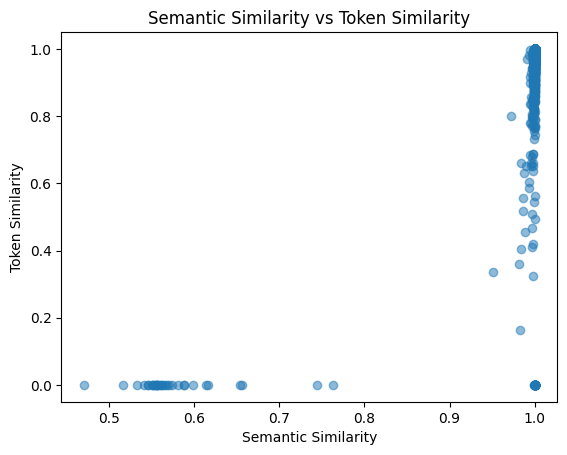

In [20]:
plt.plot(bugfix_files['Semantic_Similarity'], bugfix_files['Token_Similarity'], 'o', alpha=0.5)
plt.title('Semantic Similarity vs Token Similarity')
plt.xlabel('Semantic Similarity')
plt.ylabel('Token Similarity')
plt.show()

In [ ]:
# bugfix_files = pd.read_csv('bugfix_commit_files_MI_CC_LOC_Added_Similarity.csv')
bugfix_files.to_csv("bugfix_commit_files_MI_CC_LOC_Added_Similarity.csv")

In [19]:
bugfix_files[['Semantic_Similarity', 'Token_Similarity']].corr()

,Semantic_Similarity,Token_Similarity
Semantic_Similarity,1.000000,0.658988
Token_Similarity,0.658988,1.000000


In [51]:
bugfix_files['Semantic_class'] = bugfix_files['Semantic_Similarity'].apply(lambda x: "Minor" if x > 0.96 else "Major")
bugfix_files['Token_class'] = bugfix_files['Token_Similarity'].apply(lambda x: "Minor" if x > 0.6 else "Major")
bugfix_files['Classes Agree'] = bugfix_files['Semantic_class'] == bugfix_files['Token_class']

## Agreement between the two methods

In [52]:
bugfix_files['Classes Agree'].mean()

0.9650837988826816

In [53]:
bugfix_files['Semantic_class'].value_counts()

Semantic_class
Minor    1403
Major      29
Name: count, dtype: int64

In [54]:
bugfix_files['Token_class'].value_counts()

Token_class
Minor    1353
Major      79
Name: count, dtype: int64

In [55]:
bugfix_files['Classes Agree'].value_counts()

Classes Agree
True     1382
False      50
Name: count, dtype: int64

In [48]:
bugfix_files.to_csv("bugfix_commit_files_MI_CC_LOC_Added_Similarity_Classes.csv")

In [56]:
bugfix_files.head()

,Hash,Message,Filename,Source Code (Before),Source Code (current),Diff,LLM Inference,Rectified Message,MI_Change,CC_Change,LOC_Change,Semantic_Similarity,Token_Similarity,Semantic_class,Token_class,Classes Agree
0,014a277a97759bbc0e6ec8fba588bc6e6de65a86,A few fixes to initial point_thickness impleme...,constants.py,import os\nimport numpy as np\n\n\nGENERALLY_B...,import os\nimport numpy as np\n\nPRODUCTION_QU...,"@@ -1,9 +1,6 @@\n import os\n import numpy as ...",add more examples to the example,A few fixes to initial point_thickness impleme...,0.000000,0.0,-1.0,0.999854,0.988357,Minor,Minor,True
1,014a277a97759bbc0e6ec8fba588bc6e6de65a86,A few fixes to initial point_thickness impleme...,displayer.py,import numpy as np\nimport itertools as it\nim...,import numpy as np\nimport itertools as it\nim...,"@@ -55,7 +55,7 @@ def paint_mobjects(mobjects,...",add nudge to the thickness calculation,A few fixes to initial point_thickness impleme...,0.000000,0.0,0.0,1.000000,0.951255,Minor,Minor,True
2,014a277a97759bbc0e6ec8fba588bc6e6de65a86,A few fixes to initial point_thickness impleme...,mobject.py,import numpy as np\nimport itertools as it\nim...,import numpy as np\nimport itertools as it\nim...,"@@ -21,7 +21,7 @@ class Mobject(object):\n ...",add missing docstring,Update configuration inheritance in Mobject cl...,0.000000,0.0,0.0,0.999891,0.997525,Minor,Minor,True
3,ac930952f151acf284f6e01e98e8f7256f29f9f4,"Beginning transform KA article, many small fix...",animation.py,from PIL import Image\nfrom colour import Colo...,from PIL import Image\nfrom colour import Colo...,"@@ -4,7 +4,6 @@ import numpy as np\n import wa...",add missing code in animation,Update starting_mobject initialization in Anim...,0.225313,0.0,-1.0,0.999791,0.987431,Minor,Minor,True
4,ac930952f151acf284f6e01e98e8f7256f29f9f4,"Beginning transform KA article, many small fix...",meta_animations.py,import numpy as np\nimport itertools as it\nfr...,import numpy as np\nimport itertools as it\n\n...,"@@ -1,6 +1,5 @@\n import numpy as np\n import ...",add missing import,add missing import,0.268985,0.0,-1.0,0.999781,0.994031,Minor,Minor,True


## Analysis

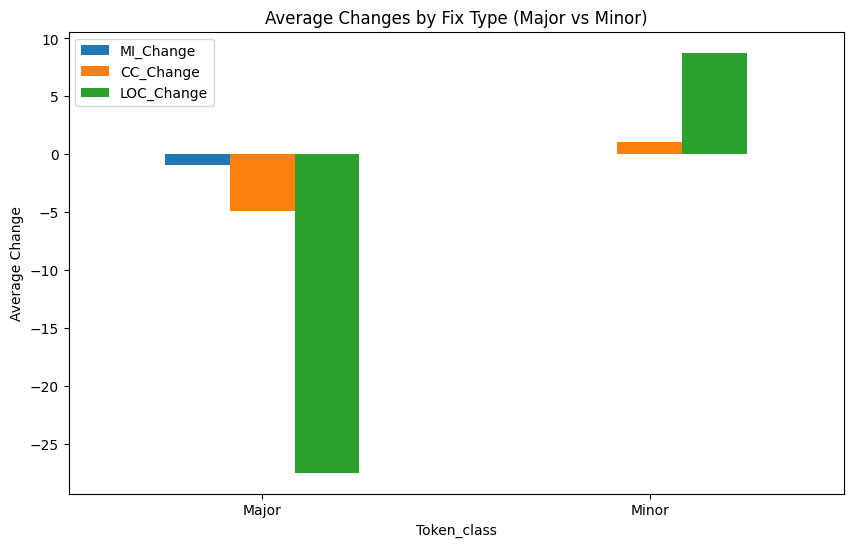

In [ ]:
grouped_data = bugfix_files.groupby('Semantic_class')[['MI_Change', 'CC_Change', 'LOC_Change']].mean()

grouped_data.plot(kind='bar', figsize=(10, 6), title='Average Changes by Fix Type (Major vs Minor)')
plt.ylabel('Average Change')
plt.xticks(rotation=0)
plt.show()

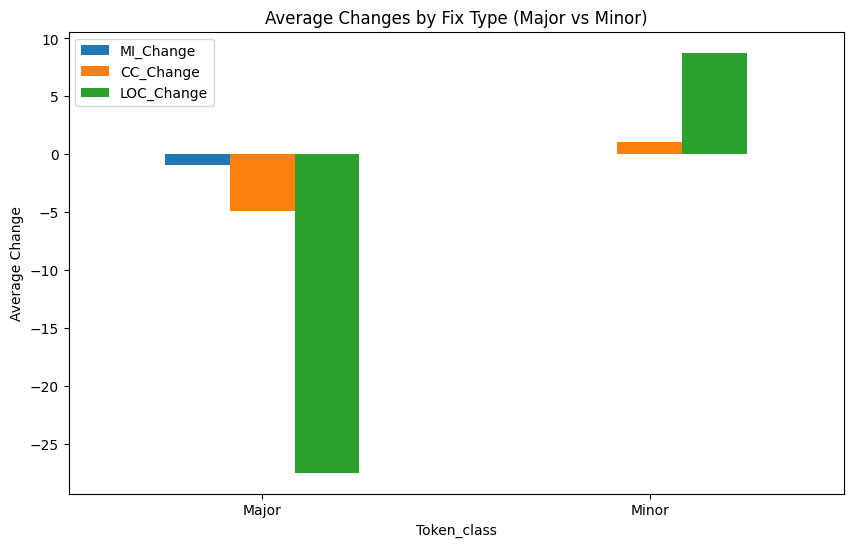

In [76]:
grouped_data = bugfix_files.groupby('Token_class')[['MI_Change', 'CC_Change', 'LOC_Change']].mean()

grouped_data.plot(kind='bar', figsize=(10, 6), title='Average Changes by Fix Type (Major vs Minor)')
plt.ylabel('Average Change')
plt.xticks(rotation=0)
plt.show()